#Import Library

In [442]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
!pip install pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Introduction

#Convert Csv file into Standard form

In [443]:
with open('/content/coursework_data.csv', 'r', newline='') as input_file, \
        open('Final.csv', 'w', newline='') as output_file:
    reader = csv.reader(input_file)
    writer = csv.writer(output_file)
    writer.writerow(['Date', 'Time'])

    for row in reader:
        if not row:
            continue

        datetime_data = row[0].split()

        if len(datetime_data) >= 2:
            writer.writerow([datetime_data[0], datetime_data[1]])


#Check outlier

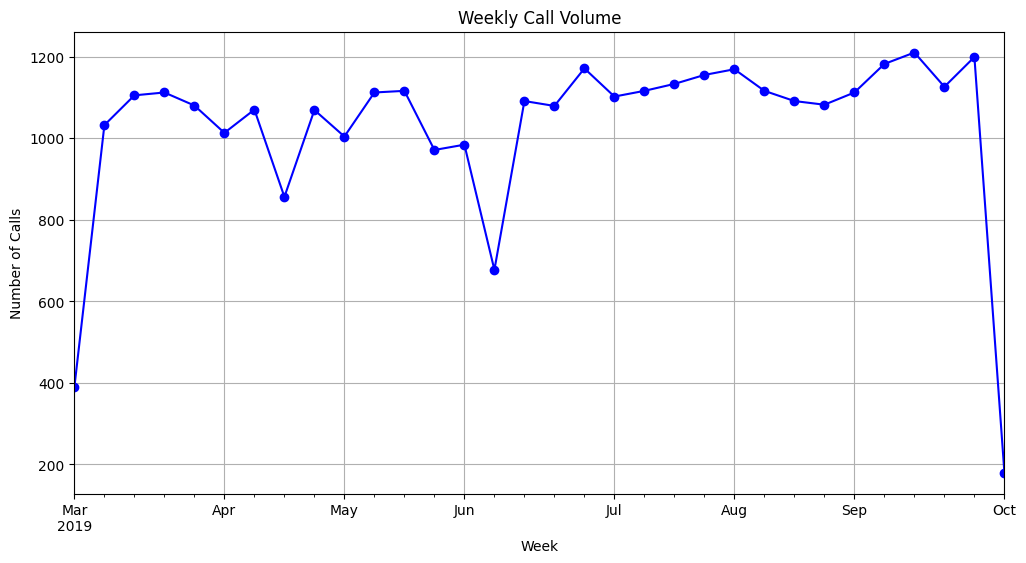

In [444]:
df4 = pd.read_csv("/content/Final.csv")

df4['Datetime'] = pd.to_datetime(df4['Date'] + ' ' + df4['Time'], format='%d/%m/%Y %H:%M:%S')

weekly_data = df4.set_index('Datetime').resample('W').size()

plt.figure(figsize=(12,6))
weekly_data.plot(marker='o', linestyle='-', color='b')
plt.title('Weekly Call Volume')
plt.xlabel('Week')
plt.ylabel('Number of Calls')
plt.grid(True)
plt.show()

#Statistical Analysis

In [445]:
df4['Datetime'] = pd.to_datetime(df4['Date'] + ' ' + df4['Time'], format='%d/%m/%Y %H:%M:%S')

# Check statistical values
statistical_values = df4.describe()
print(statistical_values)

                            Datetime
count                          32905
mean   2019-06-18 12:07:18.470961920
min              2019-03-01 00:15:39
25%              2019-04-25 10:25:54
50%              2019-06-21 11:58:52
75%              2019-08-11 16:10:36
max              2019-09-30 23:47:15


#Check duplicates using Graph

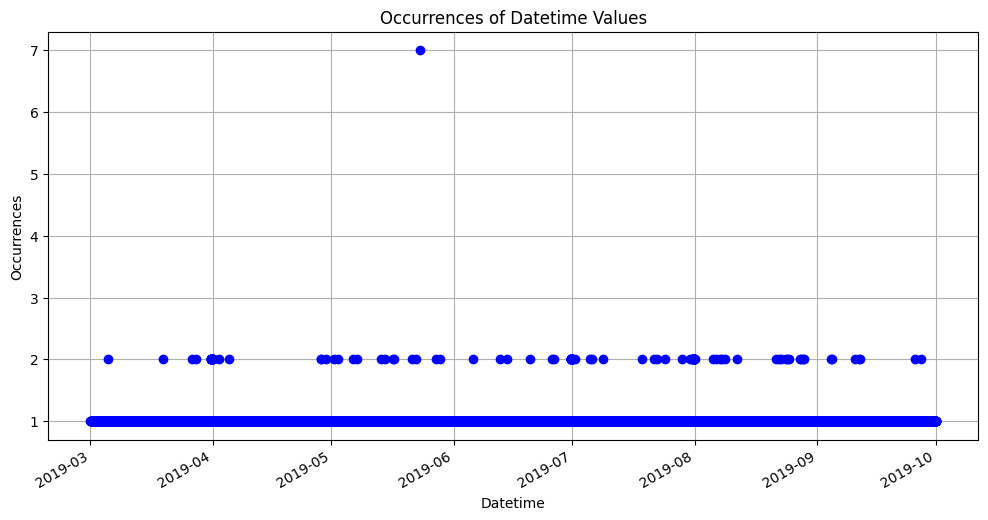

In [446]:
df3 = pd.read_csv("/content/Final.csv")
df3['Datetime'] = pd.to_datetime(df3['Date'] + ' ' + df3['Time'], format='%d/%m/%Y %H:%M:%S')

# plot a graph showing occurrences of each datetime value
plt.figure(figsize=(12, 6))
df3['Datetime'].value_counts().plot(marker='o', linestyle='', color='b')
plt.title('Occurrences of Datetime Values')
plt.xlabel('Datetime')
plt.ylabel('Occurrences')
plt.grid(True)
plt.show()

#Check duplicates and clean the data

In [447]:
df2 = pd.read_csv('/content/Final.csv')

duplicates = df2[df2.duplicated()]

if len(duplicates) > 0:
    print("Duplicate rows found:")

    df2.drop_duplicates(inplace=True)
else:
    print("No duplicate rows found.")
df2.to_csv('Final1.csv', index=False)

Duplicate rows found:


#Check Missing Value

In [448]:
missing_values = df2.isna().sum()

if missing_values.sum() > 0:
    print("Missing values found:")
else:
    print("No missing values found.")

No missing values found.


#Convert all Dates into single same date and add count ie- volume of call dates


In [449]:
df1 = pd.read_csv('/content/Final1.csv')

df1['Volume'] = ''

df1['Date'] = pd.to_datetime(df1['Date'], format='%d/%m/%Y')

df1 = df1.sort_values('Date')

date_counts = df1.groupby('Date').size().reset_index(name='Volume')

date_counts.to_csv('Final2.csv', index=False)

#Volume Over date graph

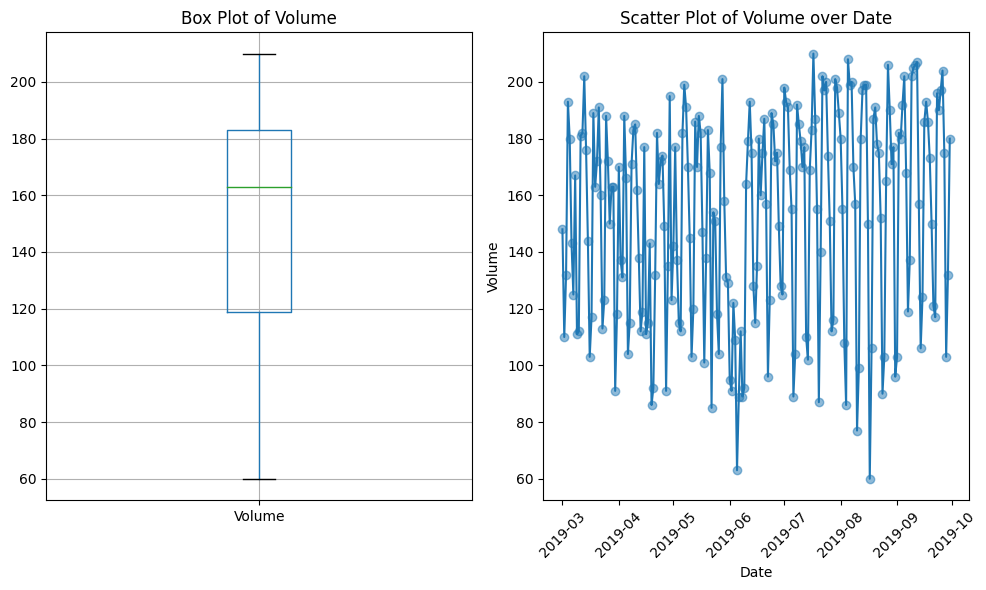

In [450]:
df = pd.read_csv('/content/Final2.csv',parse_dates=['Date'])

# Box plot
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
df.boxplot(column='Volume')
plt.title('Box Plot of Volume')

# Scatter plot
plt.subplot(1, 2, 2)
plt.scatter(df['Date'], df['Volume'], alpha=0.5)
plt.plot(df['Date'], df['Volume'])
plt.title('Scatter Plot of Volume over Date')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.tight_layout()

# Show plots
plt.show()

#Graph for one month

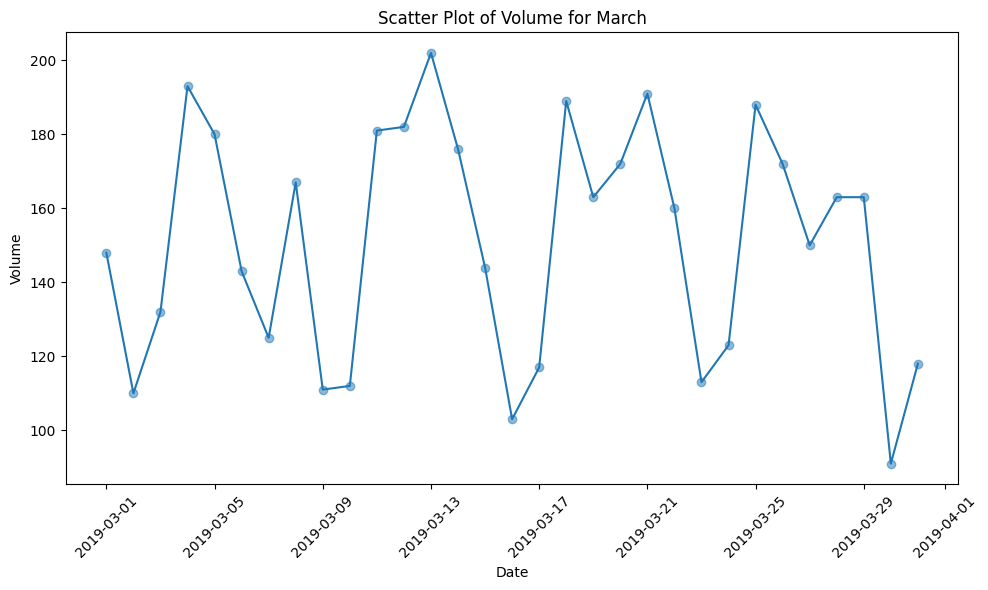

In [451]:
target_month = 3

df_target_month = df[df['Date'].dt.month == target_month]

plt.figure(figsize=(10, 6))
plt.scatter(df_target_month['Date'], df_target_month['Volume'], alpha=0.5)
plt.plot(df_target_month['Date'], df_target_month['Volume'])
plt.title('Scatter Plot of Volume for March')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

#Checking for Moving Average

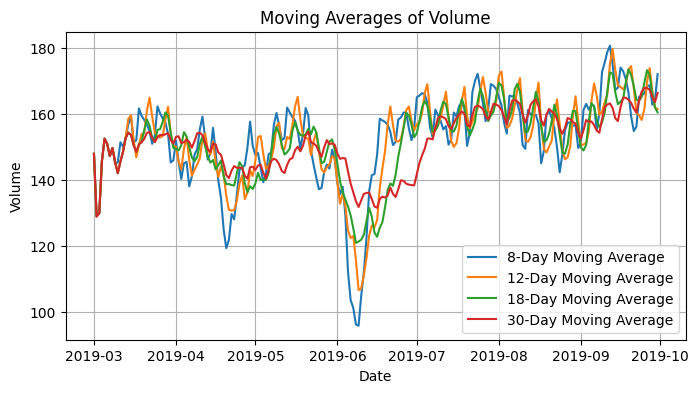

In [452]:
df = pd.read_csv("/content/Final2.csv", parse_dates=["Date"])

window_sizes = [8, 12, 18,30]
moving_avgs = {}
for window_size in window_sizes:
    moving_avgs[window_size] = df['Volume'].rolling(window=window_size, min_periods=1).mean()

plt.figure(figsize=(8, 4))
for window_size, moving_avg in moving_avgs.items():
    plt.plot(df['Date'], moving_avg, label=f'{window_size}-Day Moving Average')

plt.title('Moving Averages of Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

#Additive Seasonal Decomposition Weekly

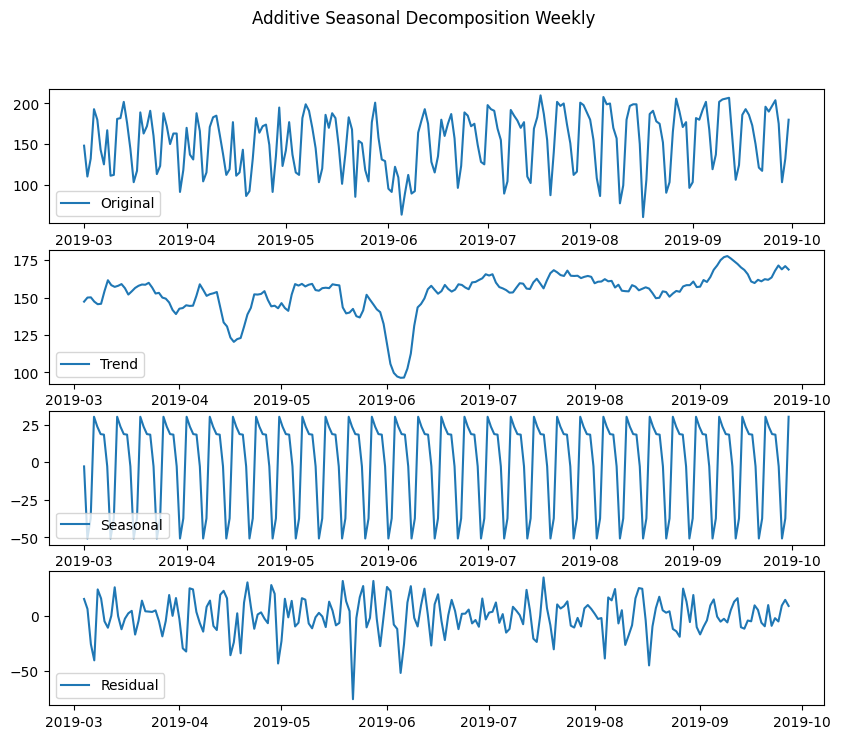

In [453]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

decomposition = seasonal_decompose(df['Volume'], model='additive', period=7)  # Assuming weekly seasonal period

plt.figure(figsize=(10, 8))

plt.subplot(4, 1, 1)
plt.plot(df.index, df['Volume'], label='Original')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend.index, decomposition.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal.index, decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid.index, decomposition.resid, label='Residual')
plt.legend()

plt.suptitle('Additive Seasonal Decomposition Weekly')
plt.show()

#Multiplicative Seasonal Decomposition Monthly

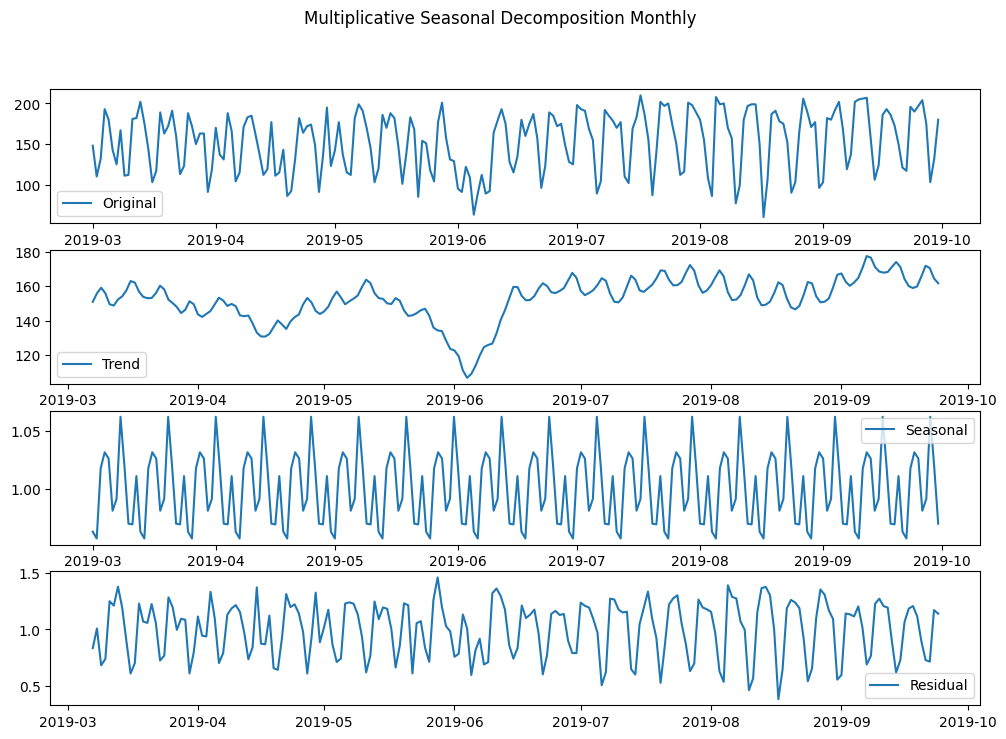

In [454]:
decomposition = seasonal_decompose(df['Volume'], model='multiplicative', period=12)  # Assuming monthly seasonal period

plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(df['Volume'], label='Original')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

plt.suptitle('Multiplicative Seasonal Decomposition Monthly')
plt.show()

#Function for Check stationarity-- ADF test

test statistic                 -2.183833
p-value                         0.212165
#lags used                     14.000000
number of observation used    199.000000
dtype: float64
1% -3.4636447617687436
5% -2.8761761179270766
10% -2.57457158581854


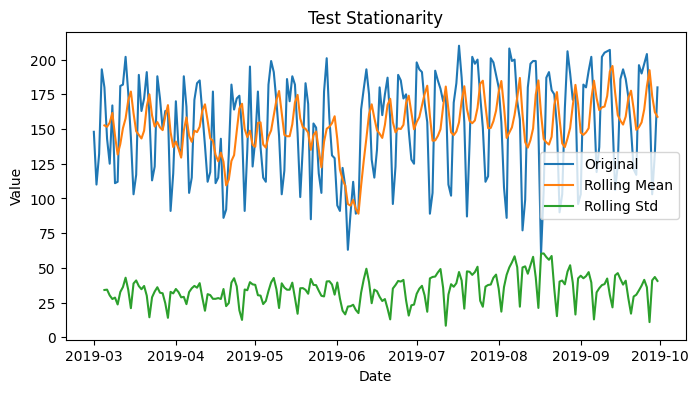

In [455]:
def test_stationarity(df, var):
    df['rollmean'] = df[var].rolling(window=5).mean()
    df['rollstd'] = df[var].rolling(window=5).std()

    adftest = adfuller(df[var], autolag='AIC')
    stats = pd.Series(adftest[0:4], index=['test statistic', 'p-value', '#lags used', 'number of observation used'])
    print(stats)
    for key, value in adftest[4].items():
        print(key, value)

    plt.figure(figsize=(8, 4))
    sns.lineplot(data=df, x='Date', y=var, label='Original')
    sns.lineplot(data=df, x='Date', y='rollmean', label='Rolling Mean')
    sns.lineplot(data=df, x='Date', y='rollstd', label='Rolling Std')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('Test Stationarity')
    plt.legend()
    plt.show()

test_stationarity(df,'Volume')

#Stationarity usings shift test

In [456]:
df['Volume_shift']=df['Volume'].shift()
df['Volume_diff']=df['Volume']-df['Volume_shift']

<ipython-input-455-7ca26961e061>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-455-7ca26961e061>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



test statistic               -6.066397e+00
p-value                       1.178970e-07
#lags used                    1.300000e+01
number of observation used    1.960000e+02
dtype: float64
1% -3.464161278384219
5% -2.876401960790147
10% -2.5746921001665974


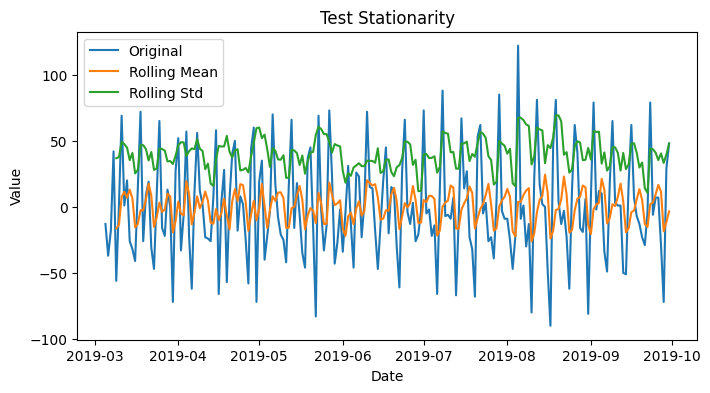

In [457]:
test_stationarity(df.dropna(),'Volume_diff')

#Stationarity using log test

In [458]:
df['Volume_log'] = df['Volume'].apply(lambda x: np.log(x))

<ipython-input-455-7ca26961e061>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-455-7ca26961e061>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



test statistic                 -2.323707
p-value                         0.164436
#lags used                     14.000000
number of observation used    195.000000
dtype: float64
1% -3.464337030867007
5% -2.876478799035722
10% -2.574733103221565


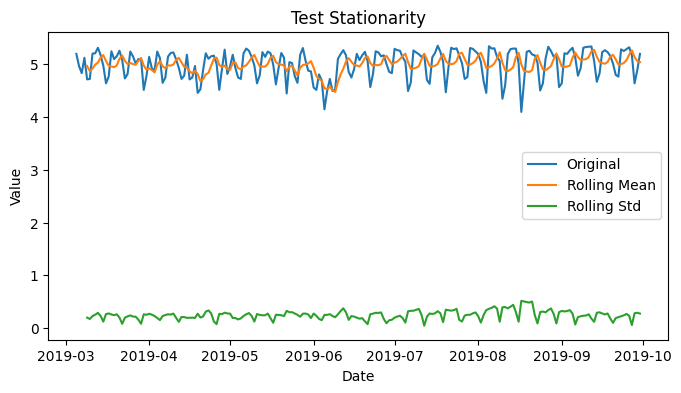

In [459]:
test_stationarity(df.dropna(),'Volume_log')

#Stationarity using SQRT test

In [460]:
df['Volume_sqrt'] = np.sqrt(df['Volume'])

<ipython-input-455-7ca26961e061>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-455-7ca26961e061>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



test statistic                 -2.247725
p-value                         0.189382
#lags used                     14.000000
number of observation used    195.000000
dtype: float64
1% -3.464337030867007
5% -2.876478799035722
10% -2.574733103221565


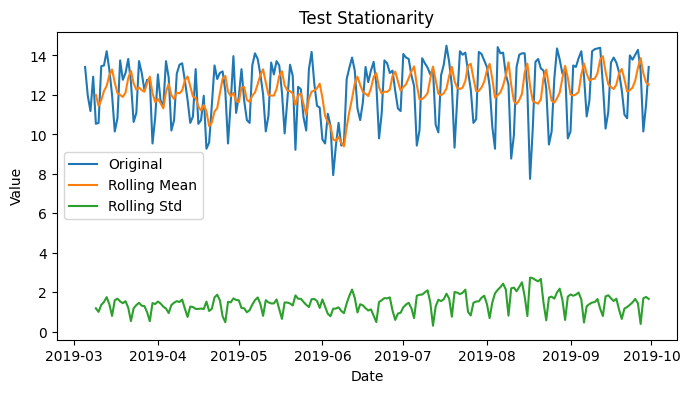

In [461]:
test_stationarity(df.dropna(),'Volume_sqrt')

#Stationarity using Exponential test

In [462]:
df['Volume_exp'] = np.exp(df['Volume'])
# df

<ipython-input-455-7ca26961e061>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-455-7ca26961e061>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



test statistic               -1.440753e+01
p-value                       8.309275e-27
#lags used                    0.000000e+00
number of observation used    2.090000e+02
dtype: float64
1% -3.4620315036789666
5% -2.8754705024827127
10% -2.5741950726860647


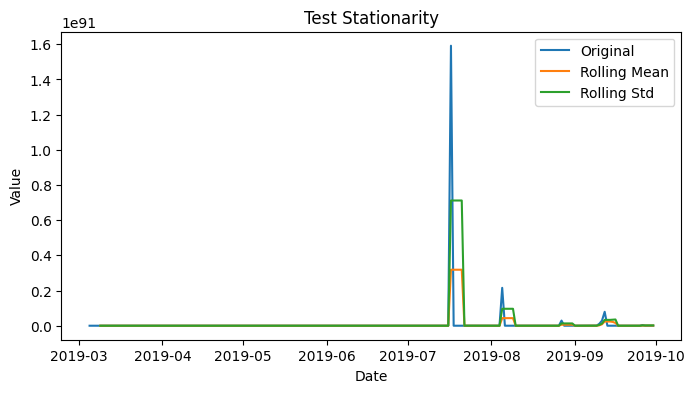

In [463]:
test_stationarity(df.dropna(),'Volume_exp')

#Stationarity using Seasonal Difference test

In [464]:
df['seasonal_diff'] = df['Volume'].diff(7)
# df

<ipython-input-455-7ca26961e061>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-455-7ca26961e061>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



test statistic                 -4.952966
p-value                         0.000027
#lags used                     13.000000
number of observation used    193.000000
dtype: float64
1% -3.4646940755442612
5% -2.8766348847254934
10% -2.5748163958763994


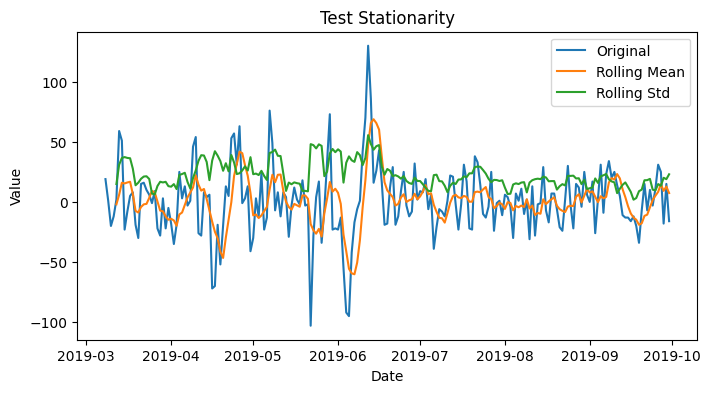

In [465]:
test_stationarity(df.dropna(),'seasonal_diff')

#Stationarity using Moving Average test

In [466]:
window_size = 5
df['moving_avg'] = df['Volume'].rolling(window=window_size).mean()

df['moving_average'] = df['Volume'] - df['moving_avg']
df

,Volume,rollmean,rollstd,Volume_shift,Volume_diff,Volume_log,Volume_sqrt,Volume_exp,seasonal_diff,moving_avg,moving_average
Date,,,,,,,,,,,
2019-03-01,148,NaN,NaN,NaN,NaN,4.997212,12.165525,1.886181e+64,NaN,NaN,NaN
2019-03-02,110,NaN,NaN,148.0,-38.0,4.700480,10.488088,5.920972e+47,NaN,NaN,NaN
2019-03-03,132,NaN,NaN,110.0,22.0,4.882802,11.489125,2.122617e+57,NaN,NaN,NaN
2019-03-04,193,NaN,NaN,132.0,61.0,5.262690,13.892444,6.589235e+83,NaN,NaN,NaN
2019-03-05,180,152.6,34.070515,193.0,-13.0,5.192957,13.416408,1.489384e+78,NaN,152.6,27.4
...,...,...,...,...,...,...,...,...,...,...,...
2019-09-26,204,180.8,36.009721,197.0,7.0,5.318120,14.282857,3.945248e+88,31.0,180.8,23.2
2019-09-27,175,192.4,10.922454,204.0,-29.0,5.164786,13.228757,1.003539e+76,25.0,192.4,-17.4
2019-09-28,103,173.8,41.008536,175.0,-72.0,4.634729,10.148892,5.399228e+44,-18.0,173.8,-70.8


<ipython-input-455-7ca26961e061>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-455-7ca26961e061>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



test statistic                 -4.693279
p-value                         0.000087
#lags used                     14.000000
number of observation used    192.000000
dtype: float64
1% -3.4648754262570978
5% -2.876714157488788
10% -2.574858699001736


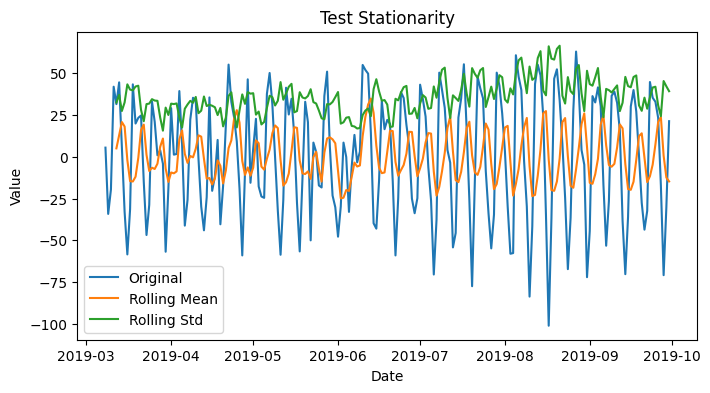

In [467]:
test_stationarity(df.dropna(),'moving_average')

In [468]:
df.to_csv('/content/Final3.csv', index=False)

#Split data into Train and Test

In [469]:
split_date = '2019-09-01'

train = df.loc[:'2019-08-31']
test = df.loc[split_date:]

print("Training set:")
print(train.head())
print("\nTesting set:")
print(test.head())

Training set:
            Volume  rollmean    rollstd  Volume_shift  Volume_diff  \
Date                                                                 
2019-03-01     148       NaN        NaN           NaN          NaN   
2019-03-02     110       NaN        NaN         148.0        -38.0   
2019-03-03     132       NaN        NaN         110.0         22.0   
2019-03-04     193       NaN        NaN         132.0         61.0   
2019-03-05     180     152.6  34.070515         193.0        -13.0   

            Volume_log  Volume_sqrt    Volume_exp  seasonal_diff  moving_avg  \
Date                                                                           
2019-03-01    4.997212    12.165525  1.886181e+64            NaN         NaN   
2019-03-02    4.700480    10.488088  5.920972e+47            NaN         NaN   
2019-03-03    4.882802    11.489125  2.122617e+57            NaN         NaN   
2019-03-04    5.262690    13.892444  6.589235e+83            NaN         NaN   
2019-03-05    5

#1- Naive Model

#1-Naive Method- predictions based on the last observed value.

In [470]:
mean_volume = train['Volume'].mean()

naive_predictions_test = [mean_volume] * len(test)
mse = mean_squared_error(test['Volume'], naive_predictions_test)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['Volume'], naive_predictions_test)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)


Mean Squared Error (MSE): 1467.310491493384
Root Mean Squared Error (RMSE): 38.30548905174536
Mean Absolute Error (MAE): 35.4231884057971


#2-Simple mean method

In [471]:
train_mean2 = train['Volume'].mean()
test_pred2 = [train_mean2] * len(test)
train_mse2 = mean_squared_error(train['Volume'], [train_mean2] * len(train))
test_mse2 = mean_squared_error(test['Volume'], test_pred2)
train_rmse2 = np.sqrt(train_mse2)
test_rmse2 = np.sqrt(test_mse2)
train_mape2 = np.mean(np.abs((train['Volume'] - train_mean2) / train['Volume'])) * 100
test_mape2 = np.mean(np.abs((test['Volume'] - train_mean2) / test['Volume'])) * 100
train_mae2 = mean_absolute_error(train['Volume'], [train_mean2] * len(train))
test_mae2 = mean_absolute_error(test['Volume'], test_pred2)

print(f'Training MSE: {train_mse2:.2f}')
print(f'Testing MSE: {test_mse2:.2f}')
print(f'Training RMSE: {train_rmse2:.2f}')
print(f'Testing RMSE: {test_rmse2:.2f}')
print(f'Training MAPE: {train_mape2:.2f}%')
print(f'Testing MAPE: {test_mape2:.2f}%')
print(f'Training MAE: {train_mae2:.2f}')
print(f'Testing MAE: {test_mae2:.2f}')

Training MSE: 1350.73
Testing MSE: 1467.31
Training RMSE: 36.75
Testing RMSE: 38.31
Training MAPE: 24.86%
Testing MAPE: 21.94%
Training MAE: 32.13
Testing MAE: 35.42


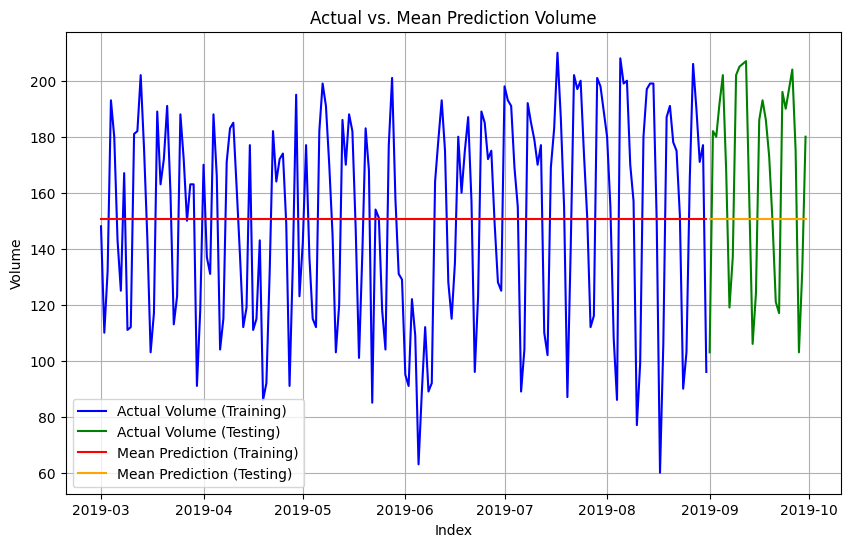

In [472]:
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Volume'], label='Actual Volume (Training)', color='blue')
plt.plot(test.index, test['Volume'], label='Actual Volume (Testing)', color='green')
plt.plot(train.index, [train_mean2] * len(train), label='Mean Prediction (Training)', color='red')
plt.plot(test.index, test_pred2, label='Mean Prediction (Testing)', color='orange')

plt.xlabel('Index')
plt.ylabel('Volume')
plt.title('Actual vs. Mean Prediction Volume')
plt.legend()
plt.grid(True)
plt.show()

#3- Moving Average

In [473]:
window_size3 = 5
train_ma3 = train['Volume'].rolling(window_size3).mean().fillna(train['Volume'].iloc[0])
test_ma3 = test['Volume'].rolling(window_size3).mean().fillna(train['Volume'].iloc[-1])
train_mse3 = mean_squared_error(train['Volume'], train_ma3)
test_mse3 = mean_squared_error(test['Volume'], test_ma3)
train_rmse3 = np.sqrt(train_mse3)
test_rmse3 = np.sqrt(test_mse3)
train_mape3 = np.mean(np.abs((train['Volume'] - train_ma3) / train['Volume'])) * 100
test_mape3 = np.mean(np.abs((test['Volume'] - test_ma3) / test['Volume'])) * 100
train_mae3 = mean_absolute_error(train['Volume'], train_ma3)
test_mae3 = mean_absolute_error(test['Volume'], test_ma3)

print(f'Training MSE: {train_mse3:.2f}')
print(f'Testing MSE: {test_mse3:.2f}')
print(f'Training RMSE: {train_rmse3:.2f}')
print(f'Testing RMSE: {test_rmse3:.2f}')
print(f'Training MAPE: {train_mape3:.2f}%')
print(f'Testing MAPE: {test_mape3:.2f}%')
print(f'Training MAE: {train_mae3:.2f}')
print(f'Testing MAE: {test_mae3:.2f}')

Training MSE: 1258.44
Testing MSE: 1956.78
Training RMSE: 35.47
Testing RMSE: 44.24
Training MAPE: 22.66%
Testing MAPE: 24.53%
Training MAE: 30.22
Testing MAE: 38.13


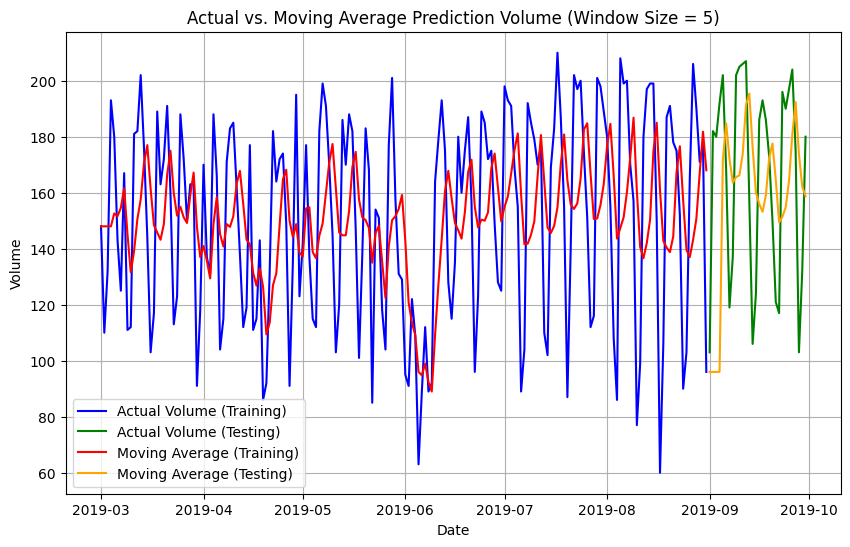

In [474]:
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Volume'], label='Actual Volume (Training)', color='blue')
plt.plot(test.index, test['Volume'], label='Actual Volume (Testing)', color='green')
plt.plot(train_ma3.index, train_ma3, label='Moving Average (Training)', color='red')
plt.plot(test_ma3.index, test_ma3, label='Moving Average (Testing)', color='orange')

plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Actual vs. Moving Average Prediction Volume (Window Size = 5)')
plt.legend()
plt.grid(True)
plt.show()

#4- Simple linear Regression

In [475]:
X_train = np.arange(len(train)).reshape(-1, 1)
X_test = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
y_train = train['Volume']
model = LinearRegression()
model.fit(X_train, y_train)
pred4 = model.predict(X_test)
test_mse4 = mean_squared_error(test['Volume'], pred4)
test_rmse4 = np.sqrt(test_mse4)
test_mape4 = np.mean(np.abs((test['Volume'] - pred4) / test['Volume'])) * 100
test_mae4 = mean_absolute_error(test['Volume'], pred4)

print(f'Testing MSE: {test_mse4:.2f}')
print(f'Testing RMSE: {test_rmse4:.2f}')
print(f'Testing MAPE: {test_mape4:.2f}%')
print(f'Testing MAE: {test_mae4:.2f}')

Testing MSE: 1291.81
Testing RMSE: 35.94
Testing MAPE: 21.44%
Testing MAE: 33.07


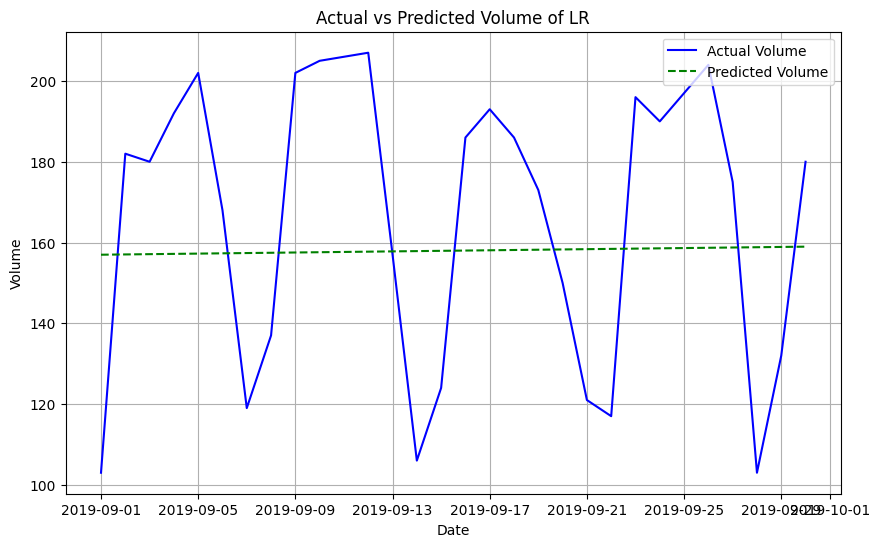

In [476]:
# Plot graph
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Volume'], label='Actual Volume', color='blue')
plt.plot(test.index, pred4, label='Predicted Volume', color='green', linestyle='--')
plt.title('Actual vs Predicted Volume of LR')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

In [477]:
import numpy as np
import statsmodels.api as sm

X_train = np.arange(len(train)).reshape(-1, 1)
X_test = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
y_train = train['Volume']

X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train)
results = model.fit()
X_test = sm.add_constant(X_test)
pred4 = results.predict(X_test)
r_squared = results.rsquared
f_statistic = results.fvalue
aic = results.aic

print(f'R-squared: {r_squared:.2f}')
print(f'F-statistic: {f_statistic:.2f}')
print(f'AIC: {aic:.2f}')

R-squared: 0.01
F-statistic: 1.81
AIC: 1850.69


#Linear Regression using lag feature

Mean Absolute Percentage Error (MAPE): 24.20858493463138
Mean Absolute Error (MAE): 27.111403508009886
Mean Squared Error (MSE): 1103.2523283972205
Root Mean Squared Error (RMSE): 33.215242410634616


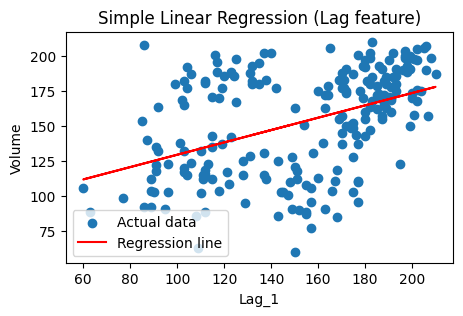

In [478]:
lm = df[['Volume']].copy()
lm['Date'] = df.index
lm['Time'] = np.arange(len(lm.index))
lm['Lag_1'] = lm['Volume'].shift(1)
lm.head()

X_ts = pd.to_numeric(lm.index).values.reshape(-1, 1)  # feature
y_ts = lm['Volume'].values  # target
lm_lag = lm.copy().dropna()

# Train the model
model_ts = LinearRegression()
model_ts.fit(X_ts, y_ts)

y_pred_ts = model_ts.predict(X_ts)

X_lag = lm_lag[["Lag_1"]]
y_lag = lm_lag['Volume']

model_lag = LinearRegression()
model_lag.fit(X_lag, y_lag)

y_lag_pred = pd.Series(model_lag.predict(X_lag))

model_lag.intercept_, model_lag.coef_

plt.figure(figsize= (5, 3))

plt.scatter(X_lag, y_lag,label='Actual data')

plt.plot(X_lag, y_lag_pred, color='red', label='Regression line')

plt.xlabel('Lag_1')
plt.ylabel('Volume')
plt.title('Simple Linear Regression (Lag feature)')
plt.legend()

y_true = lm_lag['Volume']
y_pred = y_lag_pred

mean_abs_error_am = mean_absolute_error(y_true, y_pred)
mean_square_error_am = mean_squared_error(y_true, y_pred)
root_mean_square_error_am = np.sqrt(mean_square_error_am)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true).astype(float)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape_ts = mean_absolute_percentage_error(y_ts, y_pred_ts)

print("Mean Absolute Percentage Error (MAPE):", mape_ts)
print("Mean Absolute Error (MAE):", mean_abs_error_am)
print("Mean Squared Error (MSE):", mean_square_error_am)
print("Root Mean Squared Error (RMSE):", root_mean_square_error_am)

#5- Simple Exponential Smoothing

In [479]:
model5 = SimpleExpSmoothing(train['Volume'])
model_fit5 = model5.fit()
test_pred5 = model_fit5.forecast(len(test))
train_mse5 = mean_squared_error(train['Volume'], model_fit5.fittedvalues)
test_mse5 = mean_squared_error(test['Volume'], test_pred5)
train_rmse5 = np.sqrt(train_mse5)
test_rmse5 = np.sqrt(test_mse5)
train_mape5 = np.mean(np.abs((train['Volume'] - model_fit5.fittedvalues) / train['Volume'])) * 100
test_mape5 = np.mean(np.abs((test['Volume'] - test_pred5) / test['Volume'])) * 100

train_mae5 = mean_absolute_error(train['Volume'], model_fit5.fittedvalues)
test_mae5 = mean_absolute_error(test['Volume'], test_pred5)

print(f'Training MSE: {train_mse5:.2f}')
print(f'Testing MSE: {test_mse5:.2f}')
print(f'Training RMSE: {train_rmse5:.2f}')
print(f'Testing RMSE: {test_rmse5:.2f}')
print(f'Training MAPE: {train_mape5:.2f}%')
print(f'Testing MAPE: {test_mape5:.2f}%')
print(f'Training MAE: {train_mae5:.2f}')
print(f'Testing MAE: {test_mae5:.2f}')

Training MSE: 1357.68
Testing MSE: 1552.11
Training RMSE: 36.85
Testing RMSE: 39.40
Training MAPE: 24.66%
Testing MAPE: 22.21%
Training MAE: 32.47
Testing MAE: 36.38


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



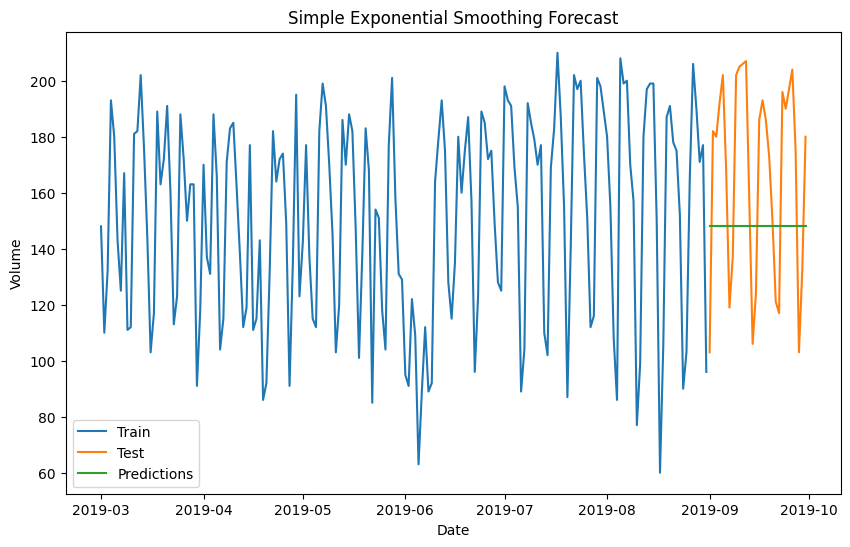

In [480]:
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Volume'], label='Train')
plt.plot(test.index, test['Volume'], label='Test')
plt.plot(test.index, test_pred5, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Simple Exponential Smoothing Forecast')
plt.legend()
plt.show()

#6- Holt Linear

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



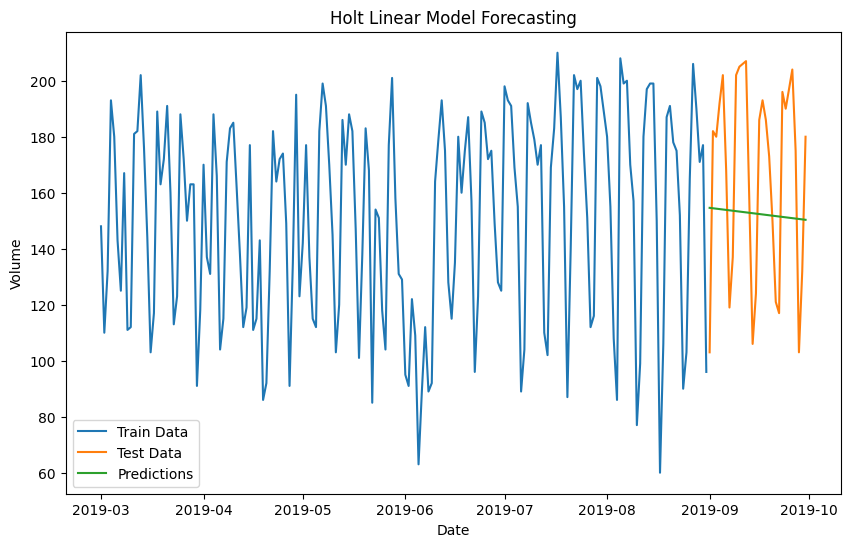

In [481]:
model6 = ExponentialSmoothing(train['Volume'], trend='add').fit()
predictions6 = model6.forecast(len(test))

plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Volume'], label='Train Data')
plt.plot(test.index, test['Volume'], label='Test Data')
plt.plot(test.index, predictions6, label='Predictions')
plt.title('Holt Linear Model Forecasting')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

In [482]:
mse6 = mean_squared_error(test['Volume'], predictions6)
rmse6 = np.sqrt(mse6)
aic = model6.aic

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape6 = mean_absolute_percentage_error(test['Volume'], predictions6)
mae6 = mean_absolute_error(test['Volume'], predictions6)

print("Mean Squared Error (MSE):", mse6)
print("Root Mean Squared Error (RMSE):", rmse6)
print("Akaike Information Criterion (AIC):", aic)
print("Mean Absolute Percentage Error (MAPE):", mape6)
print("Mean Absolute Error (MAE):", mae6)

Mean Squared Error (MSE): 1409.2128189830134
Root Mean Squared Error (RMSE): 37.53948346718443
Akaike Information Criterion (AIC): 1344.4491438596453
Mean Absolute Percentage Error (MAPE): 21.73724382565173
Mean Absolute Error (MAE): 34.71416333102942


#7- Holt Winters

In [483]:
model7 = ExponentialSmoothing(endog=train['Volume'], trend='add', seasonal='add', seasonal_periods=7)
fitted_model7 = model7.fit()
predictions7 = fitted_model7.forecast(len(test))
mse7 = mean_squared_error(test['Volume'], predictions7)
rmse7 = np.sqrt(mse7)
mae7 = mean_absolute_error(test['Volume'], predictions7)
mape7 = np.mean(np.abs((test['Volume'] - predictions7) / test['Volume'])) * 100
aic7 = fitted_model7.aic

print("Predictions:", predictions7)
print("Mean Squared Error (MSE):", mse7)
print("Root Mean Squared Error (RMSE):", rmse7)
print("Mean Absolute Error (MAE):", mae7)
print("Mean Absolute Percentage Error (MAPE):", mape7)
print("Akaike Information Criterion (AIC):", aic7)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Predictions: 2019-09-01    119.528939
2019-09-02    195.587251
2019-09-03    198.301829
2019-09-04    189.364375
2019-09-05    178.456922
2019-09-06    158.960607
2019-09-07    100.973733
2019-09-08    119.898364
2019-09-09    195.956676
2019-09-10    198.671255
2019-09-11    189.733800
2019-09-12    178.826348
2019-09-13    159.330033
2019-09-14    101.343158
2019-09-15    120.267790
2019-09-16    196.326102
2019-09-17    199.040680
2019-09-18    190.103226
2019-09-19    179.195773
2019-09-20    159.699458
2019-09-21    101.712584
2019-09-22    120.637215
2019-09-23    196.695527
2019-09-24    199.410105
2019-09-25    190.472651
2019-09-26    179.565199
2019-09-27    160.068884
2019-09-28    102.082009
2019-09-29    121.006641
2019-09-30    197.064953
Freq: D, dtype: float64
Mean Squared Error (MSE): 175.70960135045334
Root Mean Squared Error (RMSE): 13.25554983206858
Mean Absolute Error (MAE): 11.018669858623433
Mean Absolute Percentage Error (MAPE): 6.8002606890747845
Akaike Informa

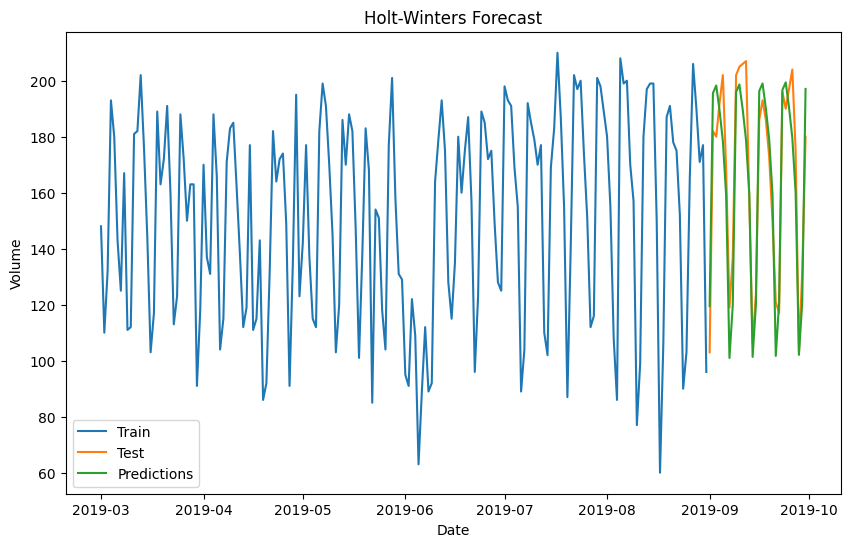

In [484]:
plt.figure(figsize=(10, 6))
plt.plot(train.index, train['Volume'], label='Train')
plt.plot(test.index, test['Volume'], label='Test')
plt.plot(test.index, predictions7, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Holt-Winters Forecast')
plt.legend()
plt.show()

In [485]:
predictions_all = fitted_model7.forecast(steps=len(test) + 61)
predictions_next_60_days = predictions_all[-60:]
print("Predictions for the next 60 days starting from the end of the training data:", predictions_next_60_days)

Predictions for the next 60 days starting from the end of the training data: 2019-10-02    190.842077
2019-10-03    179.934624
2019-10-04    160.438309
2019-10-05    102.451434
2019-10-06    121.376066
2019-10-07    197.434378
2019-10-08    200.148956
2019-10-09    191.211502
2019-10-10    180.304050
2019-10-11    160.807735
2019-10-12    102.820860
2019-10-13    121.745492
2019-10-14    197.803804
2019-10-15    200.518382
2019-10-16    191.580928
2019-10-17    180.673475
2019-10-18    161.177160
2019-10-19    103.190285
2019-10-20    122.114917
2019-10-21    198.173229
2019-10-22    200.887807
2019-10-23    191.950353
2019-10-24    181.042900
2019-10-25    161.546585
2019-10-26    103.559711
2019-10-27    122.484342
2019-10-28    198.542654
2019-10-29    201.257233
2019-10-30    192.319778
2019-10-31    181.412326
2019-11-01    161.916011
2019-11-02    103.929136
2019-11-03    122.853768
2019-11-04    198.912080
2019-11-05    201.626658
2019-11-06    192.689204
2019-11-07    181.78175

In [486]:
predicted_dates = pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), periods=len(predictions_next_60_days), freq='D')
predicted_df = pd.DataFrame({'Date': predicted_dates, 'Predicted_Volume': predictions_next_60_days})
predicted_df.to_csv('Predicted_Volume.csv', index=False)

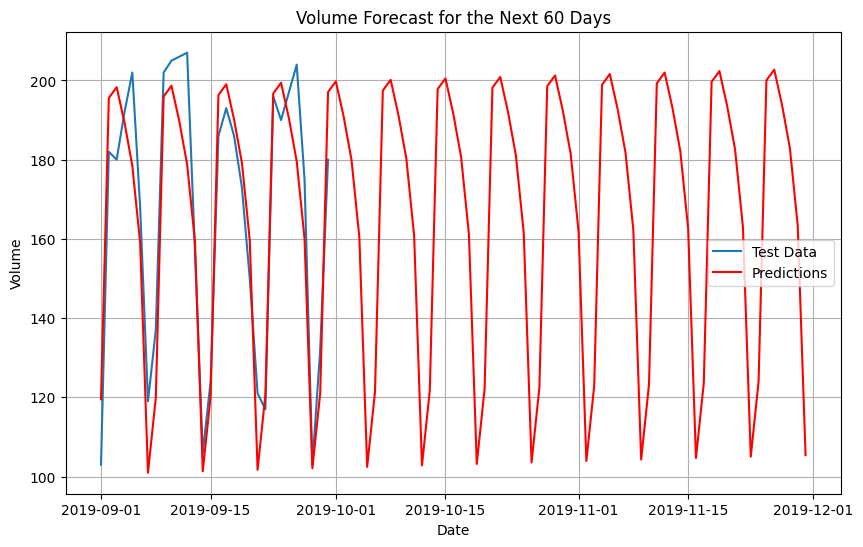

In [487]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Volume'], label='Test Data')
plt.plot(predictions_all.index, predictions_all, label='Predictions', color='red')
plt.title('Volume Forecast for the Next 60 Days')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

#8- ARIMAs using normal data / non- stationary data

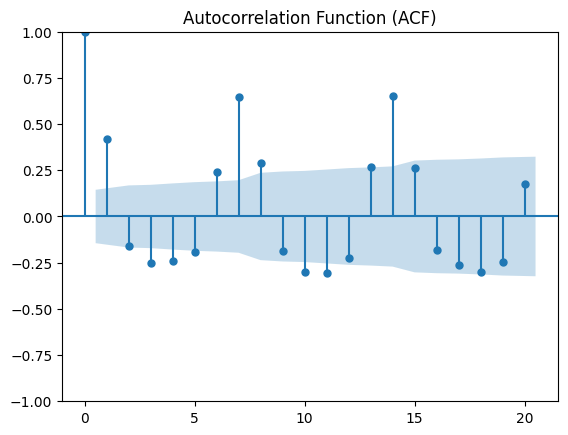

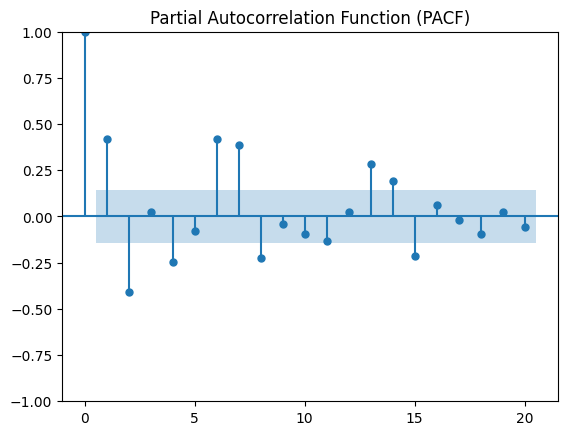

In [488]:
# Plot ACF
plot_acf(train['Volume'], lags=20)
plt.title('Autocorrelation Function (ACF)')
plt.show()

# Plot PACF
plot_pacf(train['Volume'], lags=20)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In [489]:
try:
    model8 = ARIMA(train['Volume'], order=(7,0,8))
    model_fit = model8.fit()
    print(model_fit.summary())
except Exception as e:
    print(f"An error occurred: {e}")
# Make predictions
try:
    start = len(train)
    end = len(train) + len(test) - 1
    pred8 = model_fit.predict(start=start, end=end, typ='levels')
    print(pred8)
except Exception as e:
    print(f"An error occurred during prediction: {e}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood opt

                               SARIMAX Results                                
Dep. Variable:                 Volume   No. Observations:                  184
Model:                 ARIMA(7, 0, 8)   Log Likelihood                -817.613
Date:                Mon, 29 Apr 2024   AIC                           1669.227
Time:                        22:41:21   BIC                           1723.881
Sample:                    03-01-2019   HQIC                          1691.379
                         - 08-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        150.6347     13.603     11.074      0.000     123.974     177.295
ar.L1          0.0481      0.072      0.664      0.507      -0.094       0.190
ar.L2         -0.0319      0.086     -0.372      0.7

In [490]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse = mean_squared_error(test['Volume'], pred8)
mae = mean_absolute_error(test['Volume'], pred8)

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test['Volume'], pred8)
rmse = np.sqrt(mse)
aic = model_fit.aic

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape)
print("Root Mean Squared Error (RMSE):", rmse)
print("Akaike Information Criterion (AIC):", aic)

Mean Squared Error (MSE): 339.213284147345
Mean Absolute Error (MAE): 15.57376441103756
Mean Absolute Percentage Error (MAPE): 9.717409853518994
Root Mean Squared Error (RMSE): 18.41774373117796
Akaike Information Criterion (AIC): 1669.226690006631


In [491]:
# test['Volume']

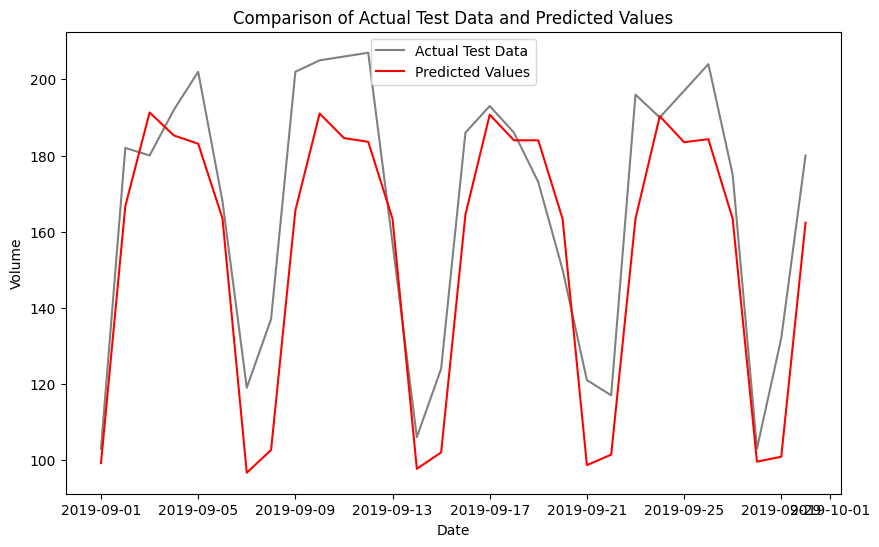

In [492]:
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Volume'], label='Actual Test Data', color='grey')
plt.plot(test.index, pred8, label='Predicted Values', color='red')
plt.title('Comparison of Actual Test Data and Predicted Values')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

In [493]:
try:
    end_test = len(train) + len(test) - 1
    start = end_test + 1
    end = start + 59
    pred8 = model_fit.predict(start=start, end=end, typ='levels')
except Exception as e:
    print(f"An error occurred during prediction: {e}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



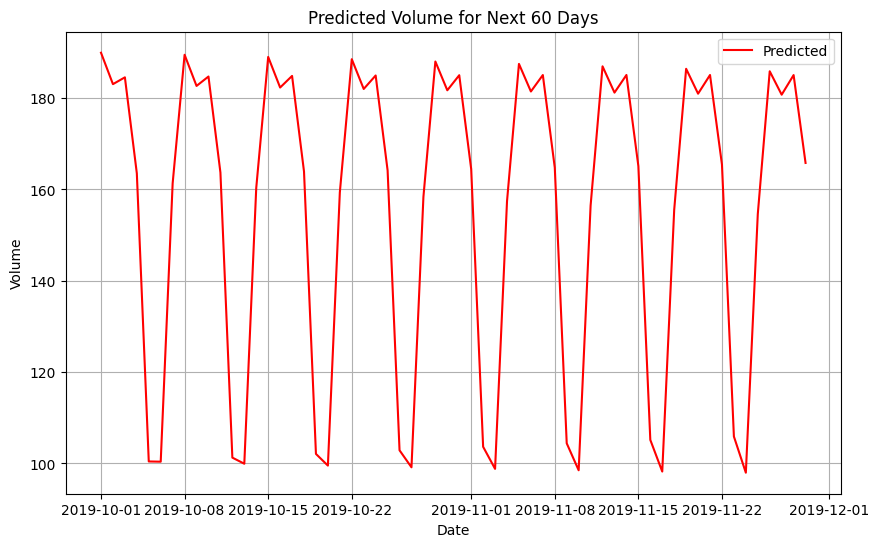

In [494]:
plt.figure(figsize=(10, 6))
plt.plot(pred8.index, pred8, label='Predicted', color='red')
plt.title('Predicted Volume for Next 60 Days')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

#8.1- ARIMAs using normal data / Stationary data

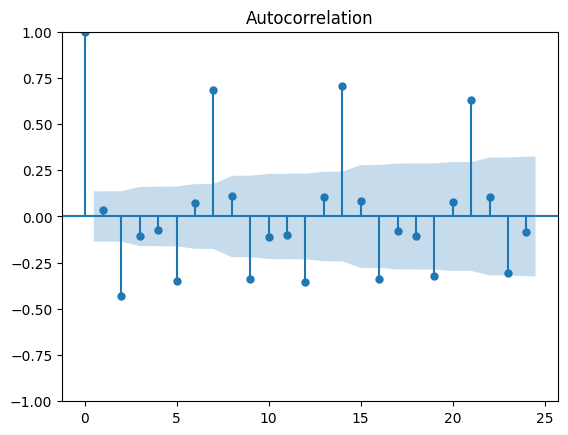

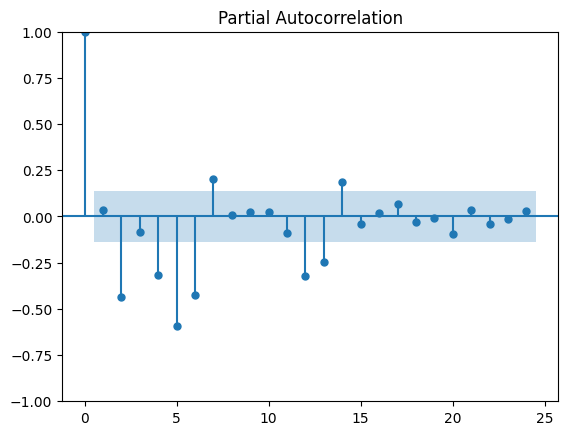

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood opt

Mean Absolute Percentage Error (MAPE): 8.786398789731036
Akaike Information Criterion (AIC): 1506.2085842980136
Mean Squared Error (MSE): 291.4436482635953
Root Mean Squared Error (RMSE): 17.07172071771312
Mean Absolute Error (MAE): 13.28496050679247


In [495]:
df["Volume_diff"] = df["Volume"].diff()
df.dropna(inplace=True)

plot_acf(df['Volume_diff'])
plot_pacf(df['Volume_diff'], method='ywm')

plt.show()
df['Volume_diff'] = df['Volume'].diff().fillna(0)

train_size = int(len(df) * 0.8)
train_diff, test_diff = df['Volume_diff'][:train_size], df['Volume_diff'][train_size:]

p, d, q = 7, 0, 8

best_mse = float('inf')
best_params = None

order = (p, d, q)

model8_1 = ARIMA(train_diff, order=order)
fit = model8_1.fit()

forecast_diff = fit.forecast(steps=len(test_diff))

forecasts8_1 = np.cumsum(forecast_diff) + df['Volume'].iloc[train_size - 1]

mse8_1 = mean_squared_error(df['Volume'].iloc[train_size:], forecasts8_1)
rmse8_1 = np.sqrt(mse8_1)
mae8_1 = mean_absolute_error(df['Volume'].iloc[train_size:], forecasts8_1)

def mean_abs_percentage_error(y_true, y_pred):
    """Calculates MAPE, handling division by zero."""
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape8_1 = mean_abs_percentage_error(df['Volume'].iloc[train_size:], forecasts8_1)

# Calculate MAPE
mape = mean_absolute_percentage_error(df['Volume'].iloc[train_size:], forecasts8_1)

# Calculate AIC
aic = fit.aic

print("Mean Absolute Percentage Error (MAPE):", mape8_1)
print("Akaike Information Criterion (AIC):", aic)
print("Mean Squared Error (MSE):", mse8_1)
print("Root Mean Squared Error (RMSE):", rmse8_1)
print("Mean Absolute Error (MAE):", mae8_1)
def plot_forecasts(forecasts: list[float], title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train['Volume'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=test['Volume'], name='Test'))
    fig.add_trace(go.Scatter(x=test.index, y=forecasts8_1, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Volume')
    return fig.show()

def plot_forecasts(forecasts, title, train, test):
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train['Volume'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=test['Volume'], name='Test'))
    fig.add_trace(go.Scatter(x=test.index, y=forecasts8_1, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Volume')
    fig.show()

# Plot forecasts
plot_forecasts(forecasts8_1, 'ARIMA Forecast', train, test)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



2019-10-01    189.503461
2019-10-02    187.027693
2019-10-03    176.316384
2019-10-04    144.249010
2019-10-05     86.236307
                 ...    
2019-11-26    187.973624
2019-11-27    192.291362
2019-11-28    177.136120
2019-11-29    141.898618
2019-11-30     94.354788
Freq: D, Name: predicted_mean, Length: 61, dtype: float64


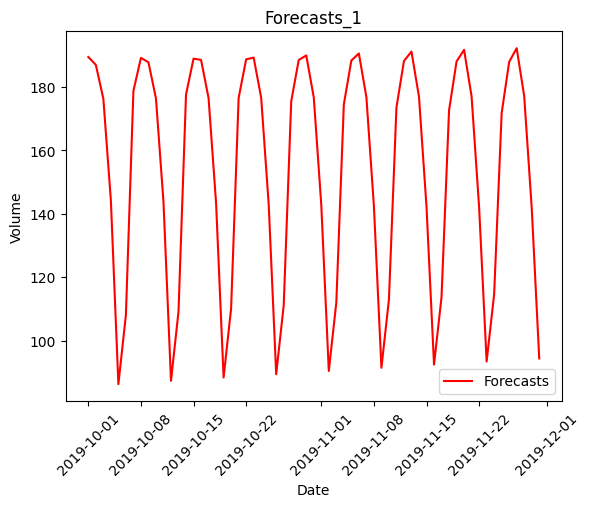

In [496]:
start = len(df)
end = start + 60

pred = fit.predict(start=start, end=end, typ='level')

forecasts_1 = np.cumsum(pred) + df['Volume'].iloc[-1]

print(forecasts_1)
plt.plot(forecasts_1.index, forecasts_1.values, label='Forecasts', color='red')

plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Forecasts_1')
plt.xticks(rotation=45)
plt.legend()
plt.show()

#9-Auto Arima

In [497]:
try:
    auto_arima_model = pm.auto_arima(train['Volume'], seasonal=True, m=7, trace=True)
except Exception as e:
    print(f"An error occurred during AutoARIMA fitting: {e}")

try:
    forecast9 = auto_arima_model.predict(len(test))
    print(forecast9)
except Exception as e:
    print(f"An error occurred during prediction: {e}")

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=1725.524, Time=5.10 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=1852.515, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=1709.854, Time=2.31 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=1749.204, Time=2.19 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=2380.267, Time=0.11 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=1818.332, Time=0.44 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=1747.385, Time=5.37 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=1750.433, Time=3.01 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=1768.431, Time=0.90 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=7.59 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=1750.367, Time=1.05 sec
 ARIMA(2,0,0)(1,0,0)[7] intercept   : AIC=1704.415, Time=2.48 sec
 ARIMA(2,0,0)(0,0,0)[7] intercept   : AIC=1784.225, Time=0.24 sec
 ARIMA(2,0,0)(2,0,0)[7] intercept   : AIC=1750.703, Time=6.04 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept   : 

Mean Squared Error (MSE): 419.308920401071


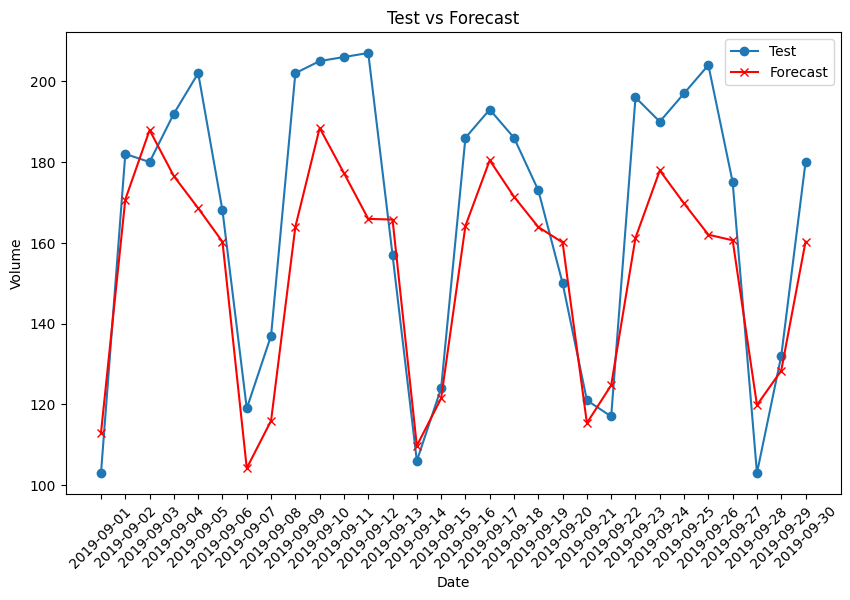

In [498]:
try:
    mse9 = mean_squared_error(test['Volume'], forecast9)
    print(f"Mean Squared Error (MSE): {mse9}")
except Exception as e:
    print(f"An error occurred during MSE calculation: {e}")
try:
    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test['Volume'], label='Test', marker='o')
    plt.plot(test.index, forecast9, label='Forecast', color='red', marker='x')
    plt.title('Test vs Forecast')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.xticks(test.index, rotation=45)
    plt.legend()
    plt.show()
except Exception as e:
    print(f"An error occurred during plotting: {e}")

#10- SARIMA using normal data / non- stationary data

In [499]:
try:
    sarima_model = SARIMAX(train['Volume'], order=(7,0,8), seasonal_order=(0, 0, 1, 12))
    sarima_fit = sarima_model.fit()
    print(sarima_fit.summary())
except Exception as e:
    print(f"An error occurred: {e}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  184
Model:             SARIMAX(7, 0, 8)x(0, 0, [1], 12)   Log Likelihood                -821.260
Date:                              Mon, 29 Apr 2024   AIC                           1676.519
Time:                                      22:42:51   BIC                           1731.173
Sample:                                  03-01-2019   HQIC                          1698.671
                                       - 08-31-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0507      0.057      0.888      0.374      -0.061       0.162
ar.L2         -0.02

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [500]:
try:
    start = len(train)
    end = len(train) + len(test) - 1
    predict10 = sarima_fit.predict(start=start, end=end, typ='levels')
    print(predict10)
except Exception as e:
    print(f"An error occurred during prediction: {e}")

2019-09-01    100.305623
2019-09-02    170.029018
2019-09-03    193.515412
2019-09-04    185.619558
2019-09-05    180.605380
2019-09-06    162.305154
2019-09-07     97.532230
2019-09-08    103.552126
2019-09-09    168.734634
2019-09-10    193.418839
2019-09-11    184.762303
2019-09-12    181.004388
2019-09-13    162.220920
2019-09-14     98.494928
2019-09-15    103.308063
2019-09-16    167.780303
2019-09-17    192.976252
2019-09-18    184.806497
2019-09-19    181.436614
2019-09-20    162.074395
2019-09-21     99.509325
2019-09-22    102.846814
2019-09-23    166.738984
2019-09-24    192.708740
2019-09-25    184.580568
2019-09-26    181.803905
2019-09-27    162.078134
2019-09-28    100.466134
2019-09-29    102.435188
2019-09-30    165.698384
Freq: D, Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



In [501]:
try:
    sarima_model = SARIMAX(train['Volume'], order=(7, 0, 8), seasonal_order=(0, 0, 1, 12))
    sarima_fit = sarima_model.fit()
    print(sarima_fit.summary())
except Exception as e:
    print(f"An error occurred: {e}")

try:
    start = len(train)
    end = len(train) + len(test) - 1
    predict10 = sarima_fit.predict(start=start, end=end, typ='levels')

    mse_sarima = mean_squared_error(test['Volume'], predict10)
    rmse_sarima = np.sqrt(mse_sarima)
    mae_sarima = mean_absolute_error(test['Volume'], predict10)
    mape_sarima = np.mean(np.abs((test['Volume'] - predict10) / test['Volume'])) * 100
    aic_sarima = sarima_fit.aic

    print("Predictions:", predict10)
    print("Akaike Information Criterion (AIC) for SARIMAX model:", aic_sarima)
    print("Mean Squared Error (MSE):", mse_sarima)
    print("Root Mean Squared Error (RMSE):", rmse_sarima)
    print("Mean Absolute Error (MAE):", mae_sarima)
    print("Mean Absolute Percentage Error (MAPE):", mape_sarima)
except Exception as e:
    print(f"An error occurred during prediction: {e}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



                                      SARIMAX Results                                       
Dep. Variable:                               Volume   No. Observations:                  184
Model:             SARIMAX(7, 0, 8)x(0, 0, [1], 12)   Log Likelihood                -821.260
Date:                              Mon, 29 Apr 2024   AIC                           1676.519
Time:                                      22:42:55   BIC                           1731.173
Sample:                                  03-01-2019   HQIC                          1698.671
                                       - 08-31-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0507      0.057      0.888      0.374      -0.061       0.162
ar.L2         -0.02

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



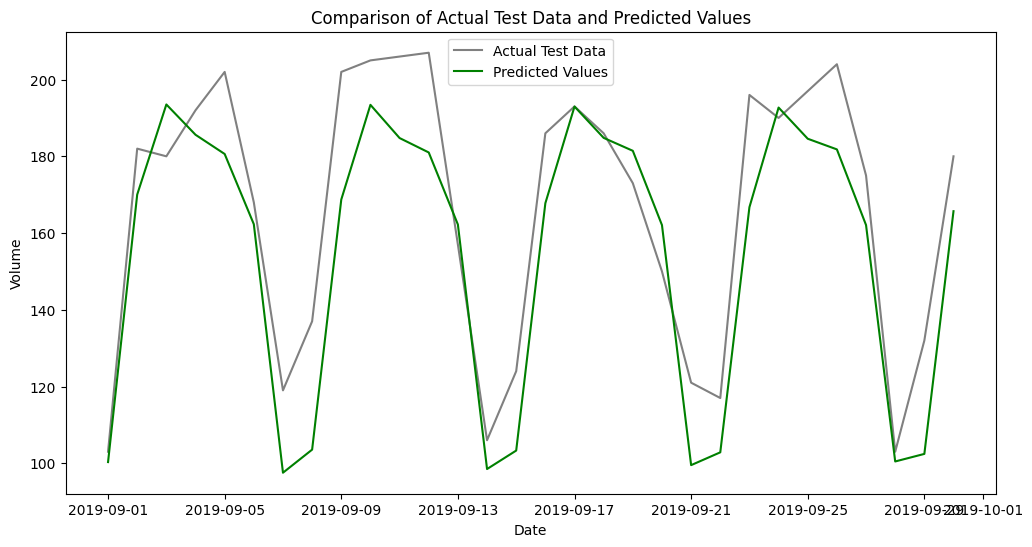

In [502]:
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Volume'], label='Actual Test Data', color='grey')
plt.plot(test.index, predict10, label='Predicted Values', color='green')
plt.title('Comparison of Actual Test Data and Predicted Values')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

#11-SARIMA using Stationary data

In [503]:
split_date = '2019-09-01'

train = df.loc[:split_date]
test = df.loc[split_date:]

df['Volume_diff'] = df['Volume'].diff().fillna(0)
train_diff = df['Volume_diff'].loc[:split_date]
test_diff = df['Volume_diff'].loc[split_date:]

model11 = SARIMAX(train_diff, order=(2, 1, 2), seasonal_order=(0, 1, 1, 7))
fit1 = model11.fit()

forecast_diff = fit1.forecast(steps=len(test_diff))

forecasts11 = np.cumsum(forecast_diff) + df['Volume'].loc[split_date]

mse11 = mean_squared_error(test['Volume'], forecasts11)
mae11 = mean_absolute_error(test['Volume'], forecasts11)
rmse11 = np.sqrt(mse11)

print("Mean Squared Error (MSE):", mse11)
print("Mean Absolute Error (MAE):", mae11)
print("Root Mean Squared Error (RMSE):", rmse11)

def plot_forecasts(forecasts, title, train, test):
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train['Volume'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=test['Volume'], name='Test'))
    fig.add_trace(go.Scatter(x=test.index, y=forecasts11, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Volume')
    fig.show()

# Plot forecasts
plot_forecasts(forecasts11, 'SARIMA Forecast', train, test)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Mean Squared Error (MSE): 1583.8798102405387
Mean Absolute Error (MAE): 30.21800048604725
Root Mean Squared Error (RMSE): 39.79798751495531


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

